In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import signal
import soundfile as sf
import keras
from keras.models import Sequential
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras import regularizers
from keras.layers import PReLU
import cv2
import librosa

In [17]:
inputData = np.empty((6898,110250))
targetData = np.empty(6898)

root = '../input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]
i_list = []
rec_annotations = []
rec_annotations_dict = {}
inputImageData = np.empty((6898,32,216))

In [18]:
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)

def slice_data(start, end, raw_data,  sample_rate):
    max_ind = len(raw_data)
    new_sample_rate = 22050
    new_raw_data = librosa.resample(raw_data,sample_rate,new_sample_rate,res_type='kaiser_fast')
    new_max_ind = len(new_raw_data)
    start_ind = min(int(start * new_sample_rate), new_max_ind)
    end_ind = min(int(end * new_sample_rate), new_max_ind)
    max_len = 110250
    if (end_ind-start_ind)>max_len:
        #print('1')
        return new_raw_data[start_ind:(start_ind+max_len)]
    elif ((end_ind-start_ind)<max_len):
        #print('2')
        return np.concatenate((new_raw_data[start_ind:end_ind],np.zeros(max_len+start_ind-end_ind)))
    elif (end_ind-start_ind)==max_len:
        #print('3')
        return new_raw_data[start_ind:end_ind]
    
def getClass(df,index):
    if(df.at[index,'Wheezes']==0 and df.at[index,'Crackles']==0):
        return 0
    elif(df.at[index,'Wheezes']==1 and df.at[index,'Crackles']==0):
        return 1
    elif(df.at[index,'Wheezes']==0 and df.at[index,'Crackles']==1):
        return 2
    elif(df.at[index,'Wheezes']==1 and df.at[index,'Crackles']==1):
        return 3

In [19]:
for s in filenames:
    (i,a) = Extract_Annotation_Data(s, root)
    i_list.append(i)
    rec_annotations.append(a)
    rec_annotations_dict[s] = a
recording_info = pd.concat(i_list, axis = 0)
del i_list
del rec_annotations

In [20]:
l=0
for i in rec_annotations_dict:
    j = rec_annotations_dict[i]
    for k in range(j.shape[0]):
        data,sampleRate = sf.read(root+i+'.wav')
        inputData[l] = slice_data(j.at[k,'Start'],j.at[k,'End'], data, sampleRate)
        targetData[l] = getClass(j,k)
        l=l+1
del rec_annotations_dict

In [21]:
sos = signal.butter(20, 5000, btype='lowpass', analog=False, output='sos', fs=220250)

In [22]:
for i in range(6898):
    inputImageData[i] = librosa.feature.mfcc(inputData[i],22050,n_mfcc=32)

1.0


[Text(0.5, 1.0, 'MFCC')]

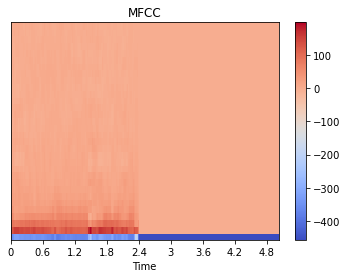

In [23]:
import librosa.display
_ = 21
print(targetData[_])
fig, ax = plt.subplots()
img = librosa.display.specshow(inputImageData[_][:][:], x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')

In [24]:
# Model configuration
img_width, img_height = 32, 216
batch_size = 256
no_epochs = 20
no_classes = 4
verbosity=1
input_shape = (img_width, img_height,1)

In [25]:
targetData = keras.utils.to_categorical(targetData, no_classes)
if K.image_data_format() == 'channels_first':
    inputImageData = inputImageData.reshape(inputImageData.shape[0], 1, img_width, img_height)
    input_shape = (1, img_width, img_height)
else:
    inputImageData = inputImageData.reshape(inputImageData.shape[0], img_width, img_height, 1)
    input_shape = (img_width, img_height, 1)


In [26]:
x_train, x_valid, y_train, y_valid = train_test_split(inputImageData, targetData, test_size=0.2, shuffle= True)

In [27]:
# Create the model
model = Sequential()
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(5,5), strides=(1, 1), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(no_classes, activation='softmax'))

Epoch 1/20
22/22 [==============================] - 1s 55ms/step - loss: 1.2466 - accuracy: 0.4996 - val_loss: 1.3412 - val_accuracy: 0.5319
Epoch 2/20
22/22 [==============================] - 1s 37ms/step - loss: 1.1028 - accuracy: 0.5366 - val_loss: 1.3252 - val_accuracy: 0.5326
Epoch 3/20
22/22 [==============================] - 1s 37ms/step - loss: 1.0673 - accuracy: 0.5466 - val_loss: 1.0342 - val_accuracy: 0.5804
Epoch 4/20
22/22 [==============================] - 1s 35ms/step - loss: 1.0301 - accuracy: 0.5698 - val_loss: 0.9841 - val_accuracy: 0.6022
Epoch 5/20
22/22 [==============================] - 1s 35ms/step - loss: 0.9781 - accuracy: 0.5886 - val_loss: 1.0181 - val_accuracy: 0.5957
Epoch 6/20
22/22 [==============================] - 1s 35ms/step - loss: 0.9539 - accuracy: 0.6078 - val_loss: 0.9603 - val_accuracy: 0.6239
Epoch 7/20
22/22 [==============================] - 1s 35ms/step - loss: 0.8902 - accuracy: 0.6325 - val_loss: 0.9402 - val_accuracy: 0.6174
Epoch 8/20
22

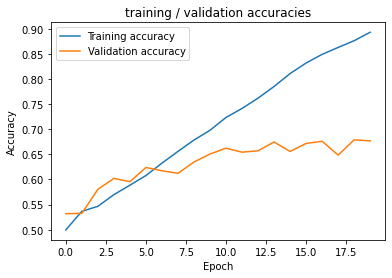

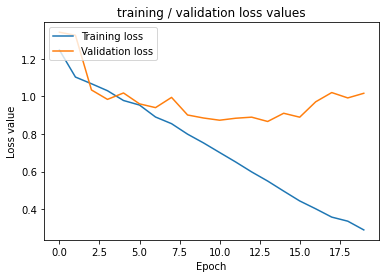

In [28]:
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
# Fit data to model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=no_epochs, verbose=verbosity, validation_data=(x_valid, y_valid))
# Visualize model history
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('training / validation accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('training / validation loss values')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()